<img src="images/unilogo.png" style="width: 200px;">

Reflectron
===============================================
Authored by: [Nathan Belmore](https://plasma.physics.berkeley.edu/faculty-staff/nathan-belmore) 
In partnership with Tobias Tubandt

Published: 9.12.2018


# Abstract
***
Mass spectrometry as a field has become very diverse, with many different methods for identifying mass to charge ratios. In this experiment, we work with a reflectron, a mass spectrometer which stores ions between to "mirrors" that reflect the particles. By trapping the ions in the mirror region, they can undergo hundreds or thousands of reflections before measurements are taken. This allows for very high-resolution mass measurements. In our experiment, we use bismuth ions produced by laser ablation. After trapping the particles, we take amplitude measurements and examine the mass resolving power as a function of the number of cycles in the experiment. 

# Physical Principles
***
Ions of different masses will experience different accelerations if accelerated by the same force for the same interval of time. With a sufficient acceleration difference, it becomes possible to differentiate between the mass differences of ions. We can use the time of flight $t$ to examine the difference of the masses.

$$t = \int_{z_1}^{z_2} \frac{dz}{v(z)} = \sqrt{\frac{m}{q}} \int_{z_1}^{z_2} \frac{dz}{2 U(z)} \approx \sqrt{\frac{m}{q}}$$

Where we pick $z$ to be the direction of motion of the particles, $v(z)$ is the velocity, and $U(z) = E \cdot d$. 

For a single stage tof measurement, typically there would be an ion source region where the ions are dropped into and first undergo acceleration. Followed by a field-free drift region and some detector. The process from ion created to measurement is precisely timed.  

| <img src="images/setup.png" style="width: 400px;">|
|----------------------------------------------------------------------------|
| Fig. 1 Generic tof measurement aparatus with a single acceleration stage. [1] |

However, single stage mass spectrometry has severe limitations. One of which is the natural energy distribution of ions from the source. This will create slight differences in time that ions of a given mass will undergo acceleration. With a given mass, it is possible to address this by measuring at the distance of the space focus plane, the point when the differences in velocities of the different ions of a given mass overlap spatially. It's possible using two stages of acceleration to control the position of the space focus plane but in both cases, the distance the ions are allowed to travel is limited. This creates an upper limit on the mass resolving power of the measurement.  


### Multi-reflection
A reflection is a multi-stage tof measurement that creates mirrored and opposite acceleration regions to reflect the ions back and forth. This also allows some degree of focusing of the ions each pass. It's possible to trap ions in this region by either switching one of the mirrors down during injection or by using a lift. The lift works by creating a region that isolated the ions from changes in the electric field (a Faraday cage), and while the ions pass through the external field is switched to bring the ions into the reflection region. 


## Experimental Setup
***
The apparatus we worked with uses an ion of Bi created through laser ablation and directed to the trapping region using a quadrupole deflector. Lens & steering electrodes are used to direct the ions into the mirror region, which are lowered into the potential by the lift. The mirrors are a series of electrodes that create the mirror potential. Once ions are in the trapping region they are allowed to oscillate for a fixed period before the lift is raised and the ions are measured at the detector. 

| <img src="images/diagram.png">
|----------------------------------------------------------------------------|
| Fig. 2 Diagram of the experimental apparatus. The ion flight path is marked with the red path. [1] |

# Analysis
***



In [1]:
# creating the correct enviroment for analysis
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import argrelextrema, savgol_filter
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## Importing the data

Some of the data sets contain multiple iterations, which are summed over to improve the statistics. 

In [2]:
# path to the data set
path = 'data/'

# some data structure for genetrating a list of the files. 
files = []

for file in os.listdir(path):
    if file.endswith(".mpa"):
        files.append(os.path.join(path, file))
files.sort()
print('Files imported:')
print(files)

# Importing the data in a pandas dataframe

# Dataset 7   
data7 = pd.read_table(files[0], header=134, sep=' ', names=['arrival time', 'slice', 'counts'])
# Converting bins to arrival times in microseconds
data7.loc[:,'arrival time'] *= 3.2 * 10**(-3)


# Dataset 13
data13 = pd.read_table(files[1], header=134, sep=' ', names=['arrival time', 'slice', 'counts'])
# Converting bins to arrival times in microseconds
data13.loc[:,'arrival time'] *= 3.2 * 10**(-3)


# Dataset 29
data29 = pd.read_table(files[2], header=135, sep=' ', names=['arrival time', 'slice', 'counts'])

Files imported:
['data/007.mpa', 'data/013.mpa', 'data/029.mpa']


## Operation without multi-reflection

The first measurement was a time of flight (tof) measurement without using multi-reflection. The source was Bi clusters. 

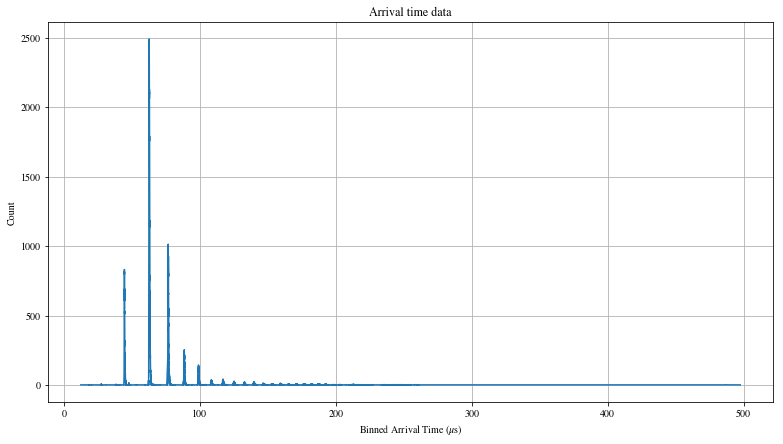

In [3]:
fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(data7['arrival time'].values, data7['counts'].values)

ax.set_xlabel('Binned Arrival Time ($\mu$s)')
ax.set_ylabel('Count')
ax.set_title('Arrival time data') 
ax.grid(True)

plt.show()

As can been seen above the peaks each corresponds to a different Bi cluster, with the first significant peak being Bi-1. The peak spacing gets smaller, which is expected because the peak spacing goes down proportional to $\sqrt m$. We can resolve the relationship between arrival time and mass for this data set by inverting the following relationship: 

$$t_{arrival} = \alpha + \beta \sqrt m $$

$$m  = (\frac{t_{arrival} - \alpha}{\beta})^2$$

To fit the values for $m$ the first step is identifying the peaks. 

/home/natephysics/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


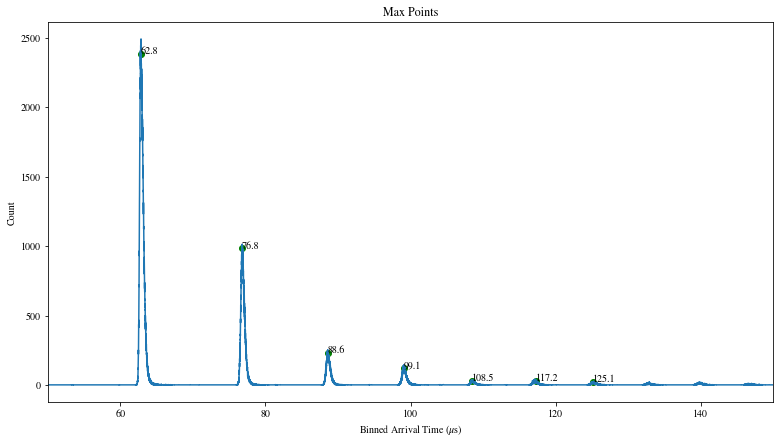

In [4]:
# number of points to be checked before and after 
n=500 

# Smoothing the data set to help
ysmoothed = savgol_filter(data7['counts'].values, 51, 3) # window size 51, polynomial order 3

# Find local peaks
max = data7.iloc[argrelextrema(ysmoothed, np.greater_equal, order=n)]

# Dropping peaks below 20 counts
max = max[max['counts'].between(20, 3000)]

# Plot results
fig, ax = plt.subplots(figsize=(13, 7))
ax.set_title('Max Points') 
ax.set_xlabel('Binned Arrival Time ($\mu$s)')
ax.set_ylabel('Count')
ax.set_xlim([50, 150])
ax.scatter(data7['arrival time'].iloc[max.index.values], data7['counts'].iloc[max.index.values], c='g')
ax.plot(data7['arrival time'], data7['counts'])

# Add labels to points
for i in max.index.values:
    ax.annotate(format(data7['arrival time'][i], '.1f'), (data7['arrival time'][i], data7['counts'][i]))
plt.show()

In [5]:
print('Table of peaks for the first 8 peaks:')
max

Table of peaks for the first 8 peaks:


,arrival time,slice,counts
681,44.5792,0,780
1914,62.8224,0,2383
3342,76.7872,0,983
4543,88.5888,0,232
5569,99.0752,0,121
6518,108.4864,0,32
7423,117.2480,0,32
8178,125.1296,0,23


Now we can fit the above values to the $m$ function. 

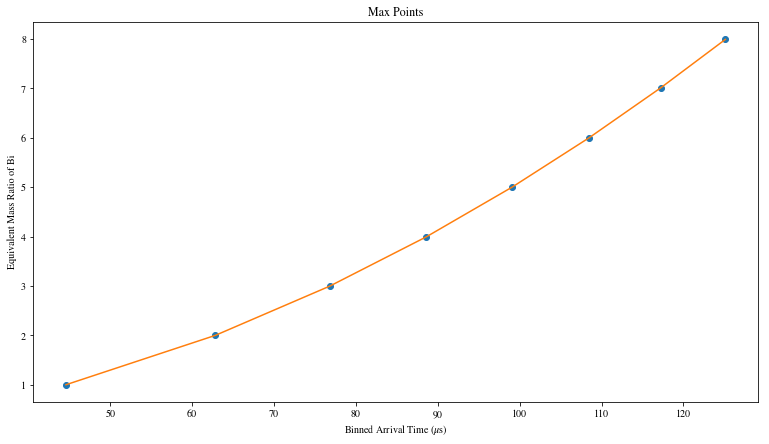

In [6]:
mass = [1, 2, 3, 4, 5, 6, 7, 8]
binned = max['arrival time'].values

# Function we are interested in fitting
def function(x, a, b):
    return ((x - b)/a)**2

# Fitting and plotting the results
popt, pcov = curve_fit(function, binned, mass)
a, b = popt

# Plot results
fig, ax = plt.subplots(figsize=(13, 7))
ax.set_title('Max Points') 
ax.set_xlabel('Binned Arrival Time ($\mu$s)')
ax.set_ylabel('Equivalent Mass Ratio of Bi')
ax.plot(binned, mass, 'o')
ax.plot(binned, function(binned, a, b));

The fit seems very successful. Using the solution above we can translate the binned arrival times into an estimate for the mass ratio in terms of Bi. 

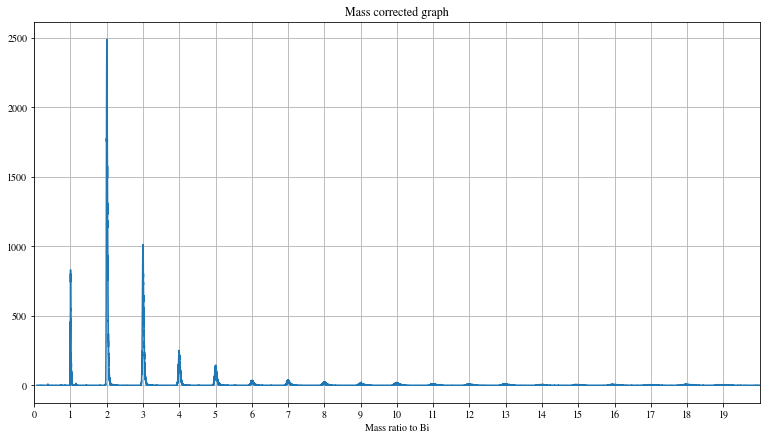

In [7]:
fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(function(data7['arrival time'].values, a, b), data7['counts'].values)

ax.set_xlabel('Mass ratio to Bi')
ax.set_title('Mass corrected graph') 
ax.set_xlim([0, 20])
ax.set_xticks(np.arange(0, 20, 1.0))
ax.grid(True)

plt.show()

### Capture a specific Cluster Size

We decided to trap and measure Bi-4. After a series of calibrations measurements we took the following trapping data. 

In [8]:
# Before we can plot it we need to restructure the data to make the process easier.
# We are going to use the .pivot method from the pandas data frame.
datamatrix = data13.pivot("slice", "arrival time", "counts").fillna(0)

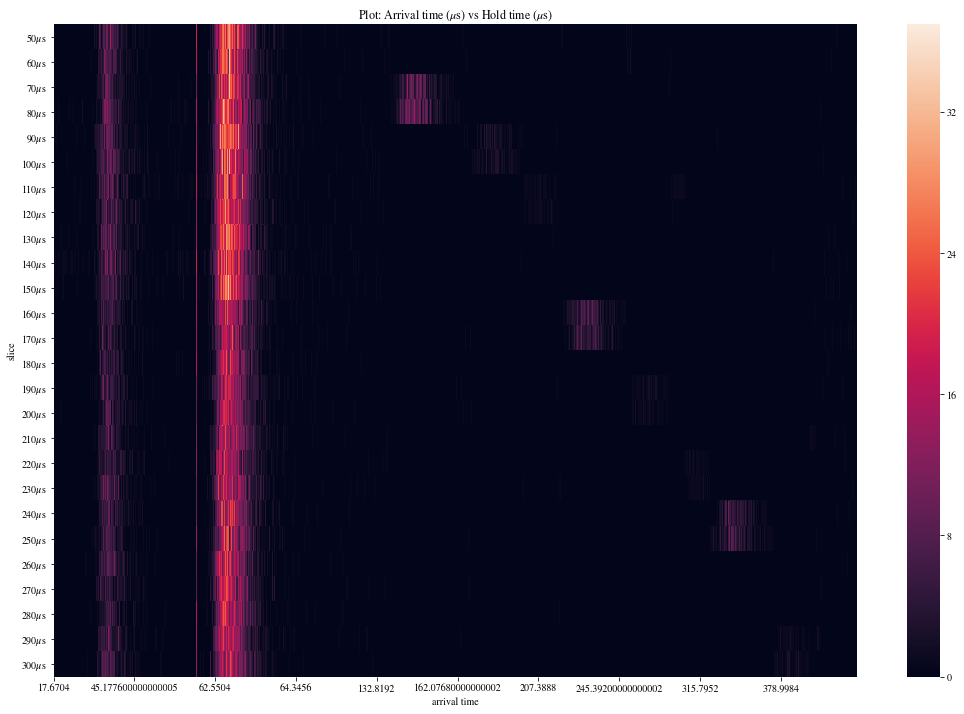

In [9]:
# Below we plot the results as a heatmap
fig = plt.figure(figsize=(18,12))
ylabels = [str(i) + '$\mu$s' for i in range(50,300+1, 10)]
r = sns.heatmap(datamatrix, xticklabels=560, yticklabels=ylabels)
r.set_title("Plot: Arrival time ($\mu$s) vs Hold time ($\mu$s)");

The first 2 bands on the plot are the result of the first two Bi clusters that make it through before lowering the lift. The intensity of the first 2 bands are quite high and aren't necessary for our analysis, so I'll drop them from the plot to focus on the more relevant data. During the lowering of the lift, we are capturing 3 different cluster sizes (labeled below). By sweeping the storage time we are moving through times for each of the 3 trapped cluster types.

<img src="images/plot.png">

### Ion Storage

After optimizing the trapping parameters for Bi-4 we examined the oscillation period $P$ in the trap. We measure the arrival time after one cycle measuring from the point of lifting the particle. After finding the mean $\tau$, we logarithmically increase the number of cycles $N$, correcting for deviations from the predicted hold time each step ($\Delta \tau$). This allows us to get a very accurate measurement of the period of oscillation by taking the total oscillation time $t_o$ and dividing by $N$.


| $N$  | $t_o$ ($\mu s$) | $\tau$ ($\mu s$) | $\Delta \tau$ ($\mu s$) |
|------|-----------------|------------------|-------------------------|
| 1    | 90              | 33.51            | 0                       |
| 2    | 190             | 35.28            | +1.77                   |
| 4    | 383             | 35.54            | +2.03                   |
| 8    | 771             | 35.36            | +1.85                   |
| 16   | 1545            | 35.38            | +1.87                   |
| 32   | 3095            | 35.38            | +1.87                   |
| 64   | 6195            | 35.42            | +1.91                   |
| 128  | 12394           | 35.42            | +1.91                   |
| 256  | 24792           | 35.18            | +1.67                   |
| 512  | 49587           | 35.30            | +1.79                   |
| 1024 | 99178.34        | 35.12            | +1.6                    |


$$P = \frac{t_0}{N} = \frac{99178.34  }{1024} = 96.86 \mu s$$


### Multireflection measurement

Using the corrected $P$ value measured above we swept over storage cycles $N$ from 100-900 in steps of 100. After fitting each of the resulting peaks we can then calculate the intensity and the mass resolving power $R = \frac{t_{total}}{2 FWHM}$ (where $t_{total}$ is the capture time + storage time + measured tof) as a function of the number of storage cycles. First, we must unpack the sparse data set; otherwise, the fits will be impacted. 

In [10]:
# Setting min and max values for the part of the data set we're interested in
min, max = np.min(data29['arrival time']), 11000

# Defining a new dataframe for the unpacked data set
new29 = pd.DataFrame(columns=['arrival time', 'slice', 'counts'])

# Unpacking the sparse data set
for j in range(0, np.max(data29['slice'])+1):
    for i in range(min, max):
        if i in data29[data29['slice'] == j]['arrival time'].values:
            new29 = new29.append(data29[(data29['slice'] == j) & (data29['arrival time'] == i)], ignore_index=True)
        else:
            new29 = new29.append({'arrival time' : i, 'slice' : j, 'counts' : 0}, ignore_index=True)

# Converting bins to TOF in microseconds 
new29.loc[:,'arrival time'] *= 3.2 * 10**(-3)

# Defining the data type of the columns. 
new29['arrival time'] = pd.to_numeric(new29['arrival time'])
new29['counts'] = pd.to_numeric(new29['counts'])

We fit each of the data sets to a Gaussian of the form:

$$f(x) = A e^{-(\frac{x-\mu}{\sigma})^2}$$

In [11]:
# Since we are only interested in the data points around one peak, we'll trim
# the data set to the range of interest to make fitting and plotting easier. 
high = 37

# The gaussian fuction to fit to
def gauss_function(x, amplitude, mean, std):
    return amplitude * np.exp(-((x - mean) / std)**2)

# Vector for recording the fit parameters
popt = pd.DataFrame(columns=['amplitude', 'mean', 'std'])

# An inital guess for the fits
p0 = [15, 33, 2]

# Fitting all the data to a gaussian. 
for i in range(9):
    # Take the correct slice of data and limiting the range to less than high.
    xfit = new29[(new29['slice'] == i) & (new29['arrival time'] < high)]['arrival time']
    yfit = new29[(new29['slice'] == i) & (new29['arrival time'] < high)]['counts']
    p0, _ = curve_fit(gauss_function, xfit, yfit, p0=p0)
    popt = popt.append({'amplitude': p0[0], 'mean': p0[1], 'std': p0[2]}, ignore_index=True)

print('Gaussian fit values as a function of cycle:')
labels=['Cycle {0}: Amplitude: {1:.2f}, Standard Deviation: {2:.2f}'.format(100 + 100 * i,
        popt['amplitude'][i],
        2.355 * np.abs(popt['std'][i])) for i in range(len(popt))]
for i in labels:
    print(i)

Gaussian fit values as a function of cycle:
Cycle 100: Amplitude: 4.63, Standard Deviation: 0.92
Cycle 200: Amplitude: 4.24, Standard Deviation: 0.98
Cycle 300: Amplitude: 4.49, Standard Deviation: 0.96
Cycle 400: Amplitude: 4.32, Standard Deviation: 1.06
Cycle 500: Amplitude: 3.99, Standard Deviation: 1.01
Cycle 600: Amplitude: 3.80, Standard Deviation: 1.02
Cycle 700: Amplitude: 3.55, Standard Deviation: 1.17
Cycle 800: Amplitude: 3.10, Standard Deviation: 1.41
Cycle 900: Amplitude: 3.05, Standard Deviation: 1.37


To get a sense of the quality of the fit we plotted the fits against the data sets.

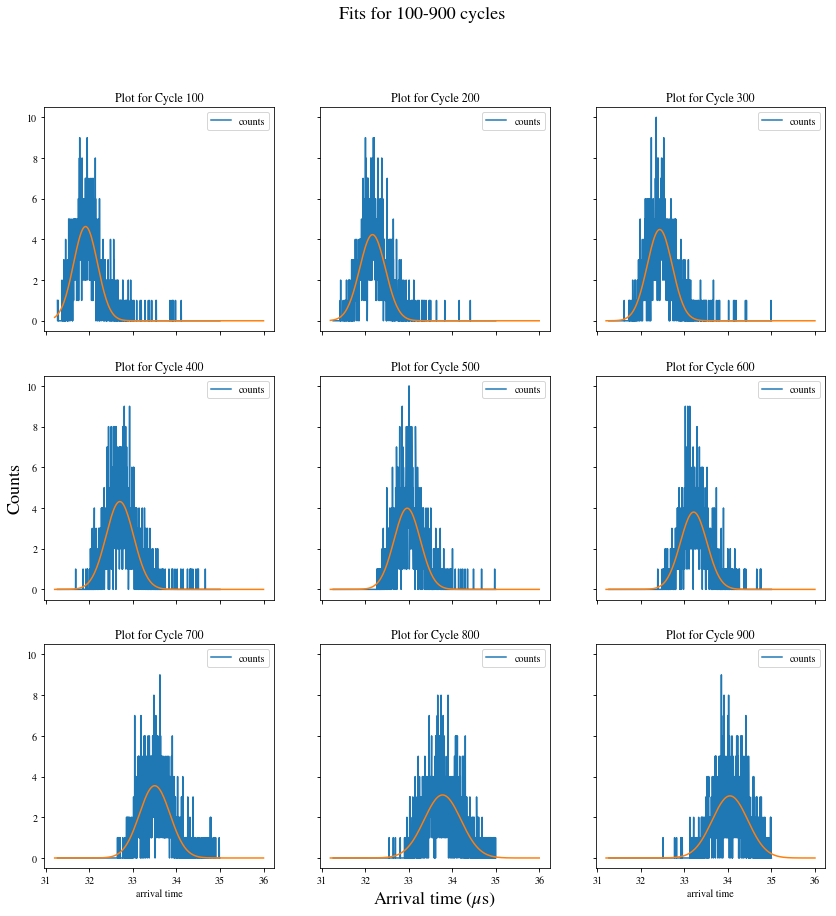

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(14, 14), sharey=True, sharex=True)

for i in range(0, 3):
    for j in range(0, 3):
        ax[i,j].set_title('Plot for Cycle {0}'.format(100 + 100 * (i*3 + j)))
        new29[(new29['slice'] == i*3 + j) & (new29['arrival time'] < 35)].plot('arrival time', 'counts', ax=ax[i,j])
        ax[i,j].plot(np.linspace(31.2, 36, 200), gauss_function(np.linspace(31.2, 36, 200), *popt.iloc[i*3 + j]))

ax[2, 1].set_xlabel('Arrival time ($\mu$s)', fontsize=18);
ax[1, 0].set_ylabel('Counts', fontsize=18);
fig.suptitle('Fits for 100-900 cycles', fontsize=18);

The fit values seemed reasonable given the data set. Using the fit parameters we can calculate $R$. 

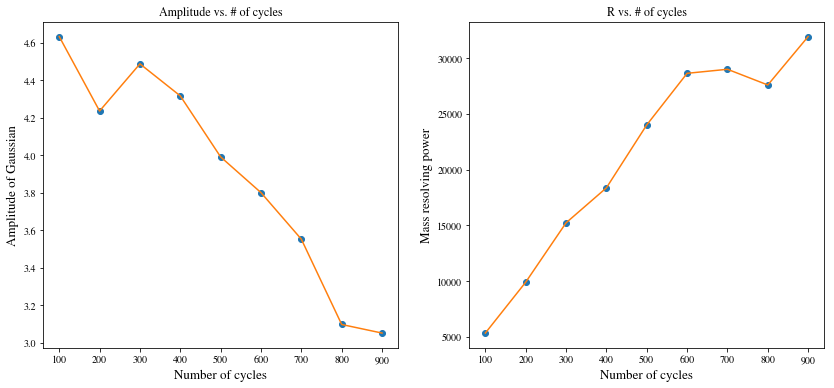

In [13]:
def rFun(i):
    """Takes in the index of the corosponding cycle and returns R,
    the mass resolving value of the measurement."""
    # tof = Capture time + storage time + measured tof   
    tof = (58) + (96.86 * (100 + 100 * i)) + (popt['mean'][i])
    fwhm = 2.35 * popt['std'][i]
    return np.round(tof / (2 * fwhm), 2)

# Vetor of the mass resolving value of the measurement.
R = [rFun(i) for i in range(0,9)]

# Setting up the plot of amplitude and R.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Amplitude plot settings
ax[0].plot(range(100, 901, 100), popt['amplitude'], 'o')
ax[0].plot(range(100, 901, 100), popt['amplitude'])
ax[0].set_title('Amplitude vs. # of cycles')
ax[0].set_ylabel('Amplitude of Gaussian', fontsize=13)
ax[0].set_xlabel('Number of cycles', fontsize=13);

# R plot settings
ax[1].plot(range(100, 901, 100), R, 'o')
ax[1].plot(range(100, 901, 100), R)
ax[1].set_title('R vs. # of cycles')
ax[1].set_ylabel('Mass resolving power', fontsize=13)
ax[1].set_xlabel('Number of cycles', fontsize=13);

As can be seen above, even though our amplitude is decreasing, because we are measuring for so many cycles we are still able to increase our mass resolving power. 

## Discussion and Conclusion
***
During this lab, we were able to get a very accurate calibration for tof for various Bi ion clusters in a single stage measurement. We conducted a series of calibration measurements to optimize the trapping of the Bi-4 ion cluster, identifying 2 other clusters (Bi-3 & Bi-5) in the trapping region as well. We took a very accurate measurement of the period of oscillation of Bi-4 inside of the mirror region of $96.86 \mu s$. We took a series of measurements, varying the number of cycles we held the Bi-4 ion cluster in the mirror region and examined the resulting distribution. There we were able to see an increase of the mass resolving power as a function of the number of cycles in the trap. 

The experimental results were as expected. The mass resolving power goes up with the number of cycles, which equates to the overall distance the ions have traveled. In the stage where we captured a specific cluster size, there are additional measurements we could take to verify the 3 cluster sizes being trapped in the ion region. For example, we could measure the cycle time for each one and compare the arrival time separation, much like we did in the single stage tof. We could also extend the data points on the last 2 graphs to see if $R$ asymptotes. Otherwise, it was very successful. 

## References
***
[1] Fortgeschrittenenpraktikum Multireflexionsflugzeitmassenspektrometer Lab Manual.